In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-12 10:53:18.065470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25(ii) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/D-25/Device-25(ii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[ 0.0078125+0.0625j     0.0390625+0.j        -0.0390625+0.0390625j ...
 -0.0078125-0.0234375j  0.1015625+0.0546875j  0.046875 +0.0390625j]
2048
78411
(2048, 78411)
[0.02889216 0.01660975 0.0053785  ... 0.00583319 0.00550056 0.0164561 ]
0
(10000, 2048)
(10000,)
[-0.0234375-0.03125j    0.03125  -0.0390625j  0.0078125+0.03125j   ...
 -0.03125  +0.0625j     0.0234375-0.046875j   0.0625   -0.0390625j]
2048
81337
(2048, 81337)
[0.03141468 0.01768619 0.01048852 ... 0.00739244 0.01048987 0.0188464 ]
1
(20000, 2048)
(20000,)
[-0.0078125-0.0078125j -0.0390625+0.0234375j -0.0078125-0.0546875j ...
  0.0234375-0.03125j    0.0546875+0.015625j  -0.0078125-0.03125j  ]
2048
77535
(2048, 77535)
[0.02909132 0.01692267 0.00512614 ... 0.00613394 0.00625093 0.0165682 ]
2
(30000, 2048)
(30000,)
[ 0.046875 +0.0234375j  0.0234375+0.j         0.0625   +0.j        ...
 -0.046875 +0.0390625j  0.03125  -0.015625j   0.0078125-0.0078125j]
2048
82068
(2048, 82068)
[0.03213584 0.01857948 0.00639128 ... 0.02845637 0.02

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-25(ii) dataset 

In [5]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-03-11 16:45:53.287351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.5369 - accuracy: 0.7962
test loss, test acc: [0.5368574857711792, 0.7961750030517578]


In [7]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 7 7]
0
[[7139    0    0    0  293 2568    0    0]
 [   0 9949    5    0    0   44    0    2]
 [   0    0 7001   22   32 2791  153    1]
 [   0    0    0 9987    0    0   13    0]
 [ 256    0    3    0 9247  494    0    0]
 [   0    1 4772   13  492 4593  128    1]
 [   0    0 2833   12    6  448 6701    0]
 [  39    0  344    0    0  438  102 9077]]
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     10000
           1       1.00      0.99      1.00     10000
           2       0.47      0.70      0.56     10000
           3       1.00      1.00      1.00     10000
           4       0.92      0.92      0.92     10000
           5       0.40      0.46      0.43     10000
           6       0.94      0.67      0.78     10000
           7       1.00      0.91      0.95     10000

    accuracy                           0.80     80000
   macro avg       0.84      0.80  

Test Accuracy:0.796175


Text(0.5, 1.0, 'Accuracy:0.796')

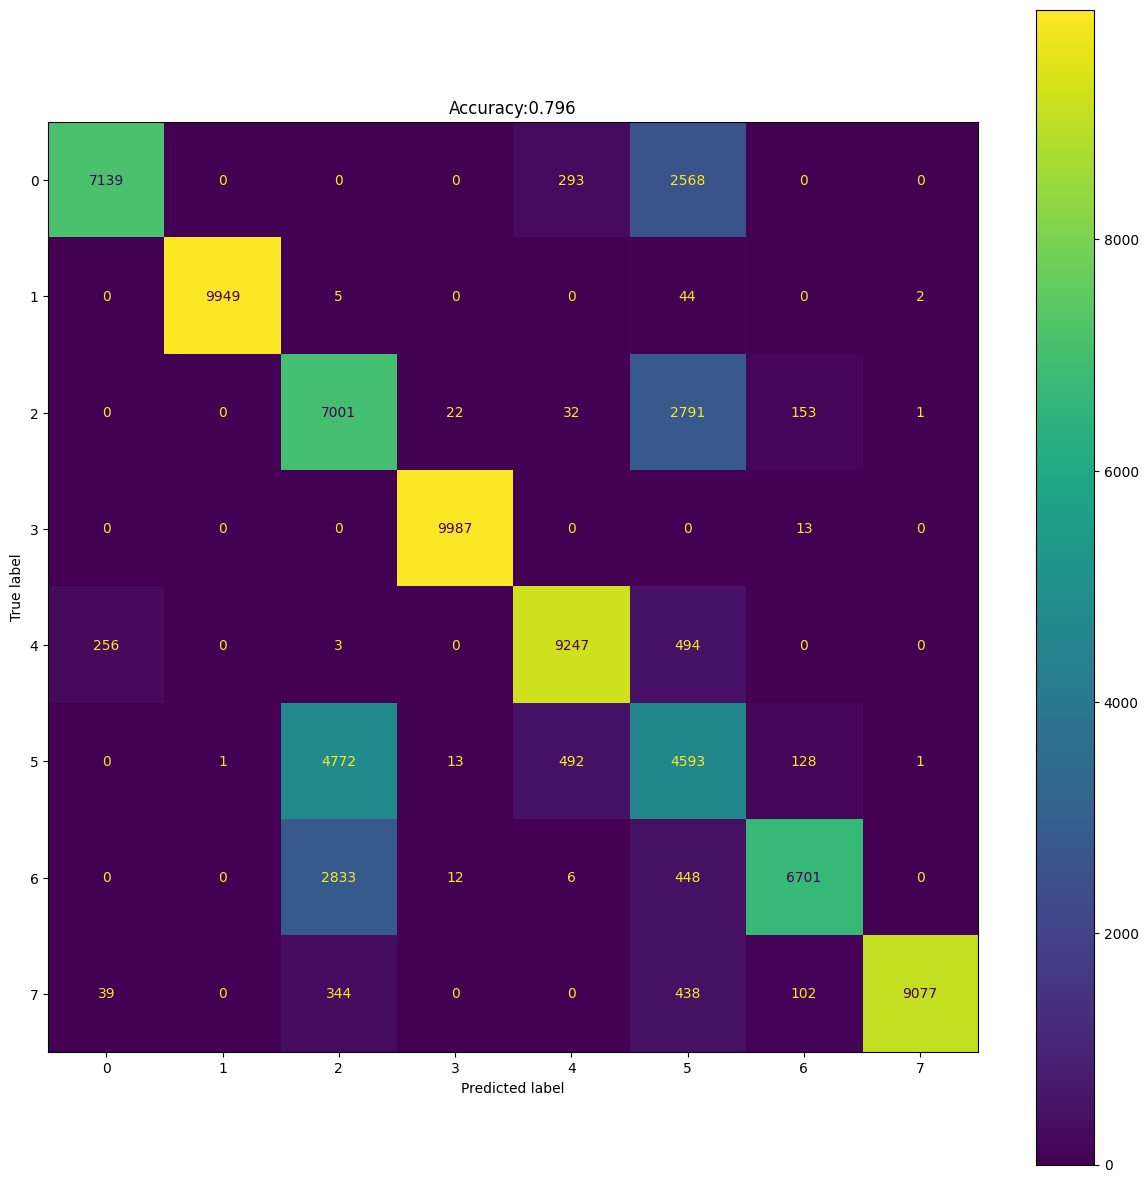

In [8]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(i) model to Nordic Device-25(ii) dataset 

In [9]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [10]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [11]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3763 - accuracy: 0.8548
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3020 - accuracy: 0.8775
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2731 - accuracy: 0.8911
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2576 - accuracy: 0.9004
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2478 - accuracy: 0.9063
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2410 - accuracy: 0.9097
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2358 - accuracy: 0.9123
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2317 - accuracy: 0.9144
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2285 - accuracy: 0.9157
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss:

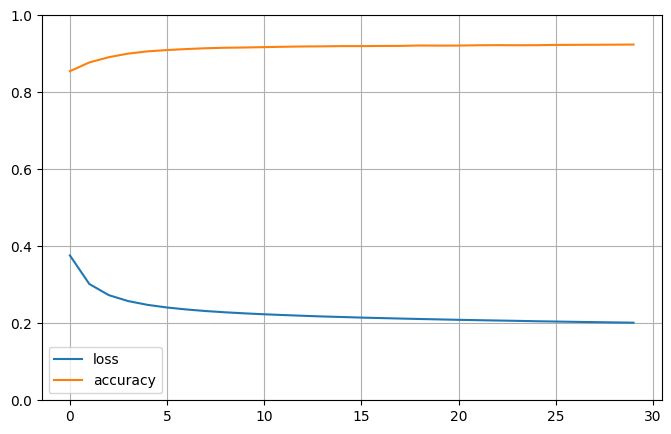

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [13]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2011 - accuracy: 0.9242
test loss, test acc: [0.20108366012573242, 0.9241999983787537]


In [14]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 7 7]
0
[[9448    0    2    0  457   85    0    8]
 [   0 9959    7    0    0   31    1    2]
 [  21    0 7567    3    5 1855  514   35]
 [   0    0    0 9956    0    0   44    0]
 [ 414    0    0    0 9433  153    0    0]
 [  72    2 1303    1  153 8252  181   36]
 [   9    0  413    4    3  103 9463    5]
 [  36    1   64    0    0   14   27 9858]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       1.00      1.00      1.00     10000
           2       0.81      0.76      0.78     10000
           3       1.00      1.00      1.00     10000
           4       0.94      0.94      0.94     10000
           5       0.79      0.83      0.81     10000
           6       0.93      0.95      0.94     10000
           7       0.99      0.99      0.99     10000

    accuracy                           0.92     80000
   macro avg       0.92      0.92  

Test Accuracy:0.9242


Text(0.5, 1.0, 'Accuracy:0.924')

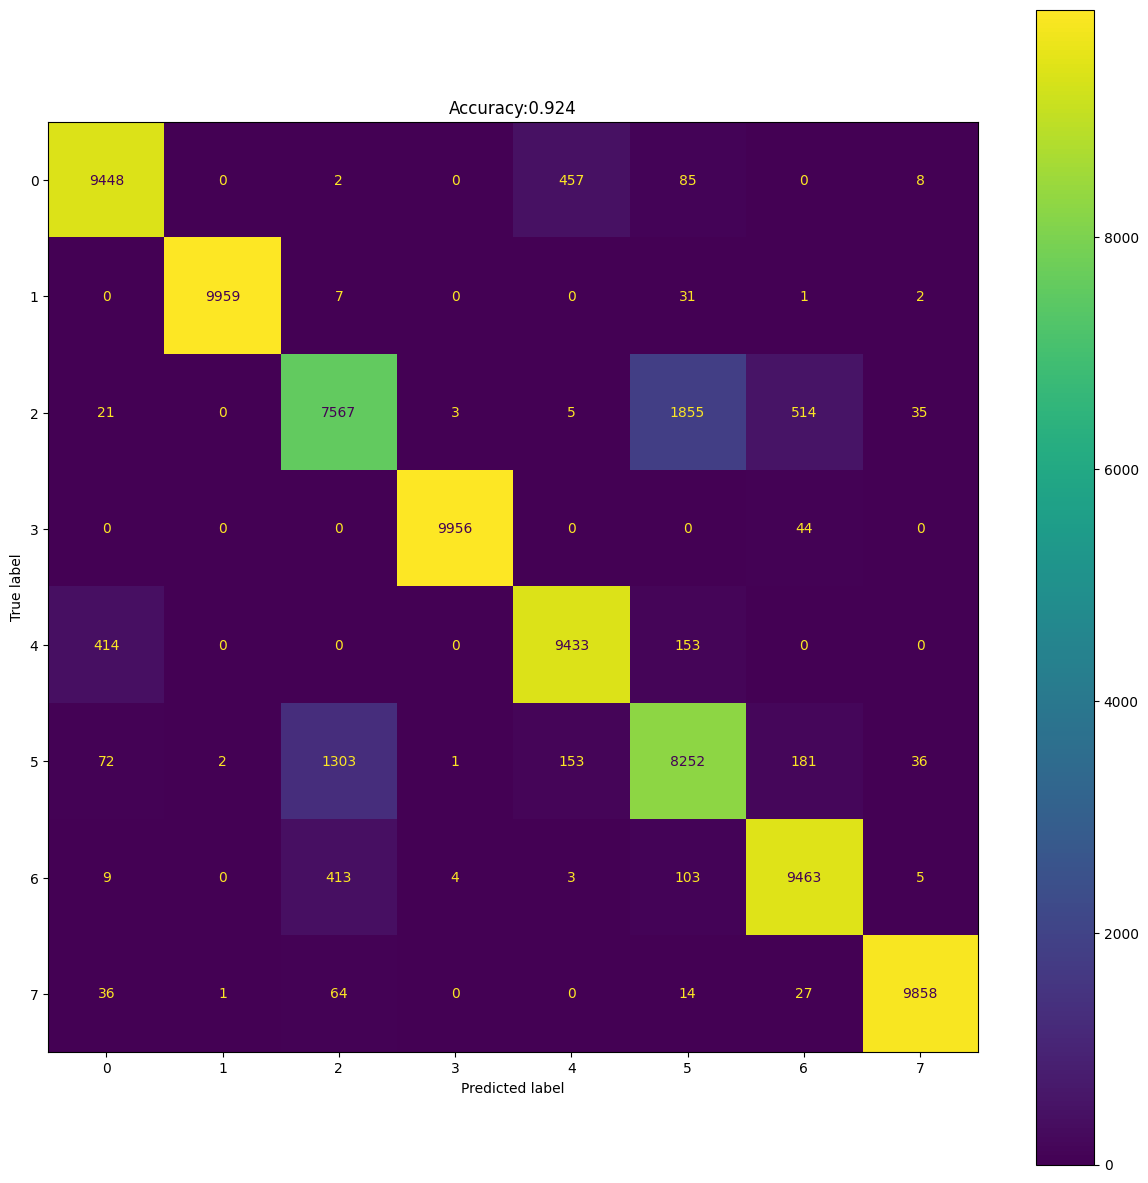

In [15]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-25(ii) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

2023-04-12 11:09:23.720074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 4.3492 - accuracy: 0.1440
test loss, test acc: [4.3491597175598145, 0.14401249587535858]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 5 1 6]
5
[[ 250   80 1121  260  199 7582  332  176]
 [ 338   58 6077  895  354  983  782  513]
 [ 367   80 1861  323  779 6008  435  147]
 [ 422   65 2522   56  313 5840  599  183]
 [ 482  110 1336  302 1315 6003  336  116]
 [ 253   62  734  170 1219 7076  361  125]
 [ 141  134 2100  319  273 6381  382  270]
 [ 330  731 2247  581 1132 3699  757  523]]
              precision    recall  f1-score   support

           0       0.10      0.03      0.04     10000
           1       0.04      0.01      0.01     10000
           2       0.10      0.19      0.13     10000
           3       0.02      0.01      0.01     10000
           4       0.24      0.13      0.17     10000
           5       0.16      0.71      0.26     10000
           6       0.10      0.04      0.05     10000
           7       0.25      0.05      0.09     10000

    accuracy                           0.14     80000
   macro avg       0.13      0.14  

Test Accuracy:0.1440125


Text(0.5, 1.0, 'Accuracy:0.144')

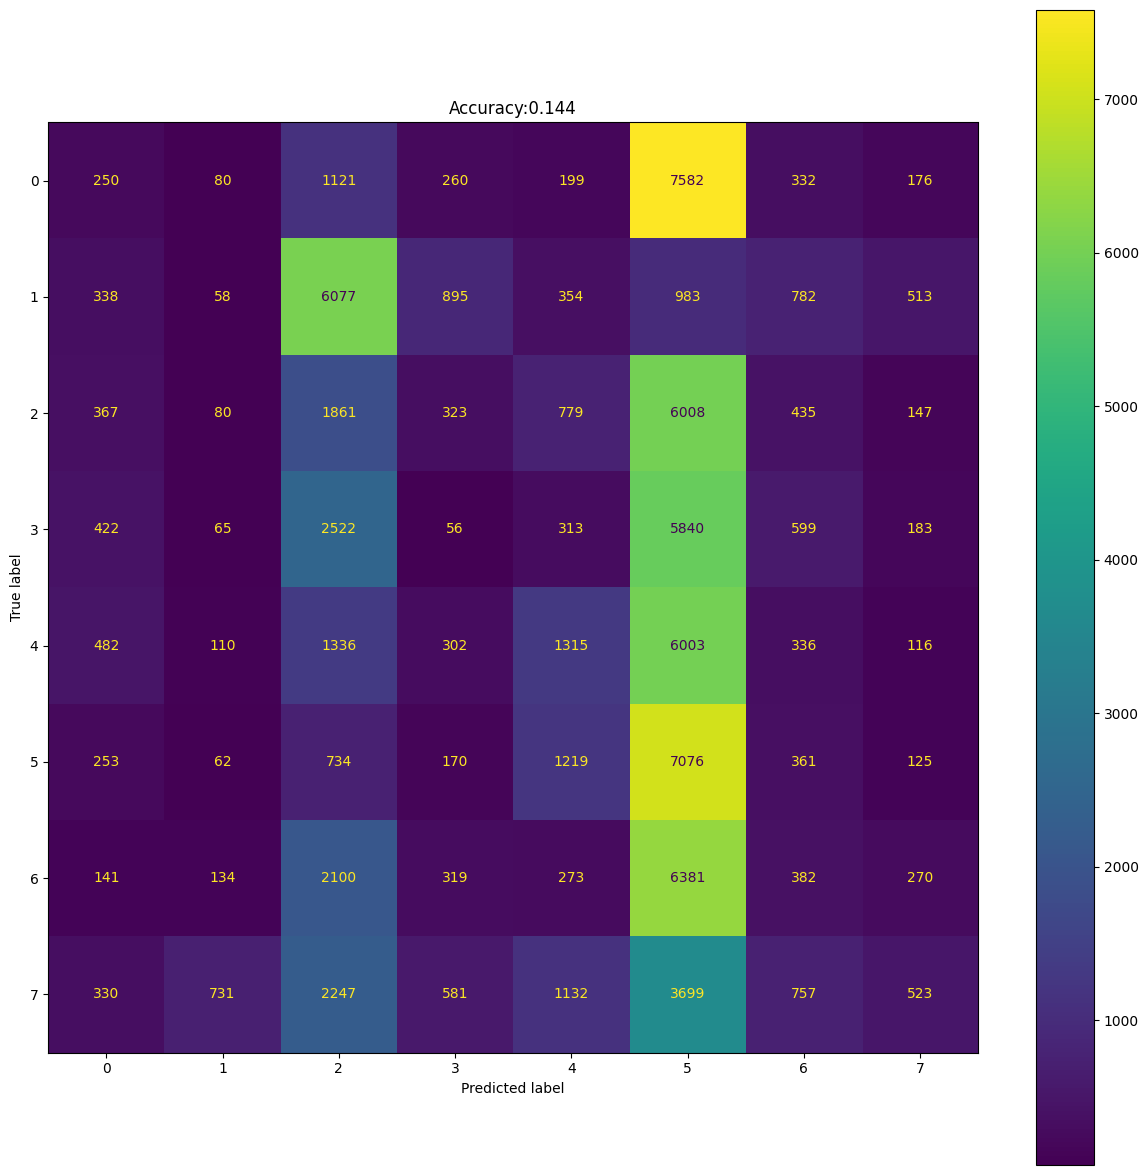

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(iii) model to Nordic Device-25(ii) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.9765 - accuracy: 0.1560
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.0814 - accuracy: 0.2408
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7814 - accuracy: 0.3376
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6691 - accuracy: 0.3909
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6104 - accuracy: 0.4173
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5719 - accuracy: 0.4342
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5425 - accuracy: 0.4472
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5186 - accuracy: 0.4575
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4979 - accuracy: 0.4668
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - los

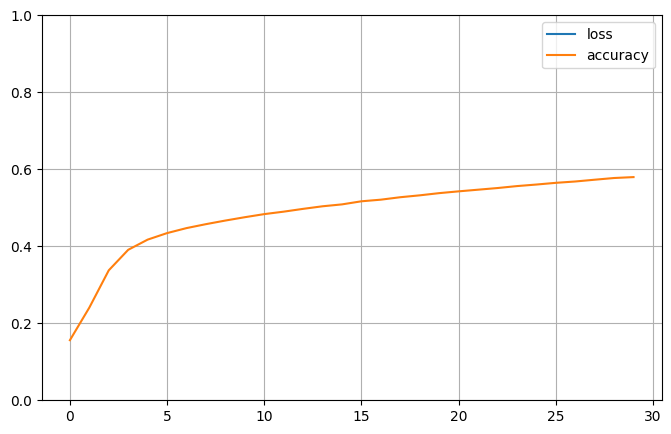

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2547 - accuracy: 0.5788
test loss, test acc: [1.2547491788864136, 0.5787624716758728]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 0 5 ... 5 7 7]
7
[[5812  147  520  339  331 1638  452  761]
 [  58 9316   27   13  240  102  141  103]
 [1495  392 2416  512  845 2872  769  699]
 [ 252   74   78 8070  145  441  854   86]
 [ 551  269  229  196 5993 1661  268  833]
 [1177  105  810  369 1066 5657  333  483]
 [1418  362  887 1063  481 1462 3589  738]
 [ 786 1127  193  142 1026  965  313 5448]]
              precision    recall  f1-score   support

           0       0.50      0.58      0.54     10000
           1       0.79      0.93      0.85     10000
           2       0.47      0.24      0.32     10000
           3       0.75      0.81      0.78     10000
           4       0.59      0.60      0.60     10000
           5       0.38      0.57      0.46     10000
           6       0.53      0.36      0.43     10000
           7       0.60      0.54      0.57     10000

    accuracy                           0.58     80000
   macro avg       0.58      0.58  

Test Accuracy:0.5787625


Text(0.5, 1.0, 'Accuracy:0.579')

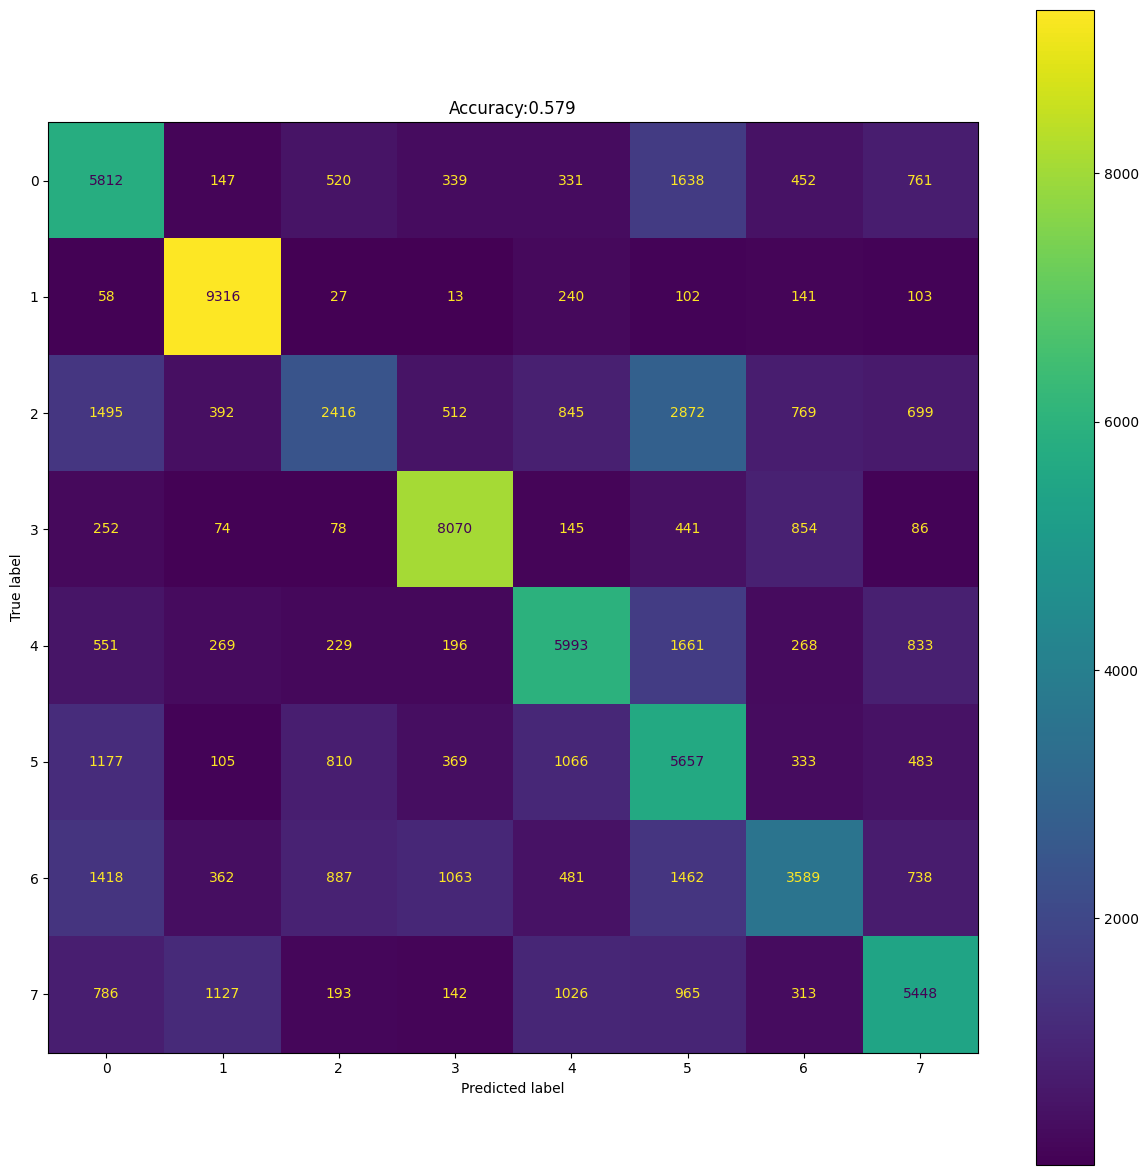

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-25(ii) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 4.7712 - accuracy: 0.1359
test loss, test acc: [4.771243572235107, 0.13592499494552612]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 2 1 ... 5 5 5]
5
[[ 860    8  757  130  415 7376  142  312]
 [1581    1  111  585 1674 4170  440 1438]
 [1947   12  818  152  887 5187  698  299]
 [ 799  182 7048  192   78 1326  271  104]
 [1130   13  749   81  773 6594  321  339]
 [1018   12 1311  184  774 6029  374  298]
 [1307    9 1193   88  672 5950  437  344]
 [2104   14  232   72  518 4940  356 1764]]
              precision    recall  f1-score   support

           0       0.08      0.09      0.08     10000
           1       0.00      0.00      0.00     10000
           2       0.07      0.08      0.07     10000
           3       0.13      0.02      0.03     10000
           4       0.13      0.08      0.10     10000
           5       0.15      0.60      0.23     10000
           6       0.14      0.04      0.07     10000
           7       0.36      0.18      0.24     10000

    accuracy                           0.14     80000
   macro avg       0.13      0.14  

Test Accuracy:0.135925


Text(0.5, 1.0, 'Accuracy:0.136')

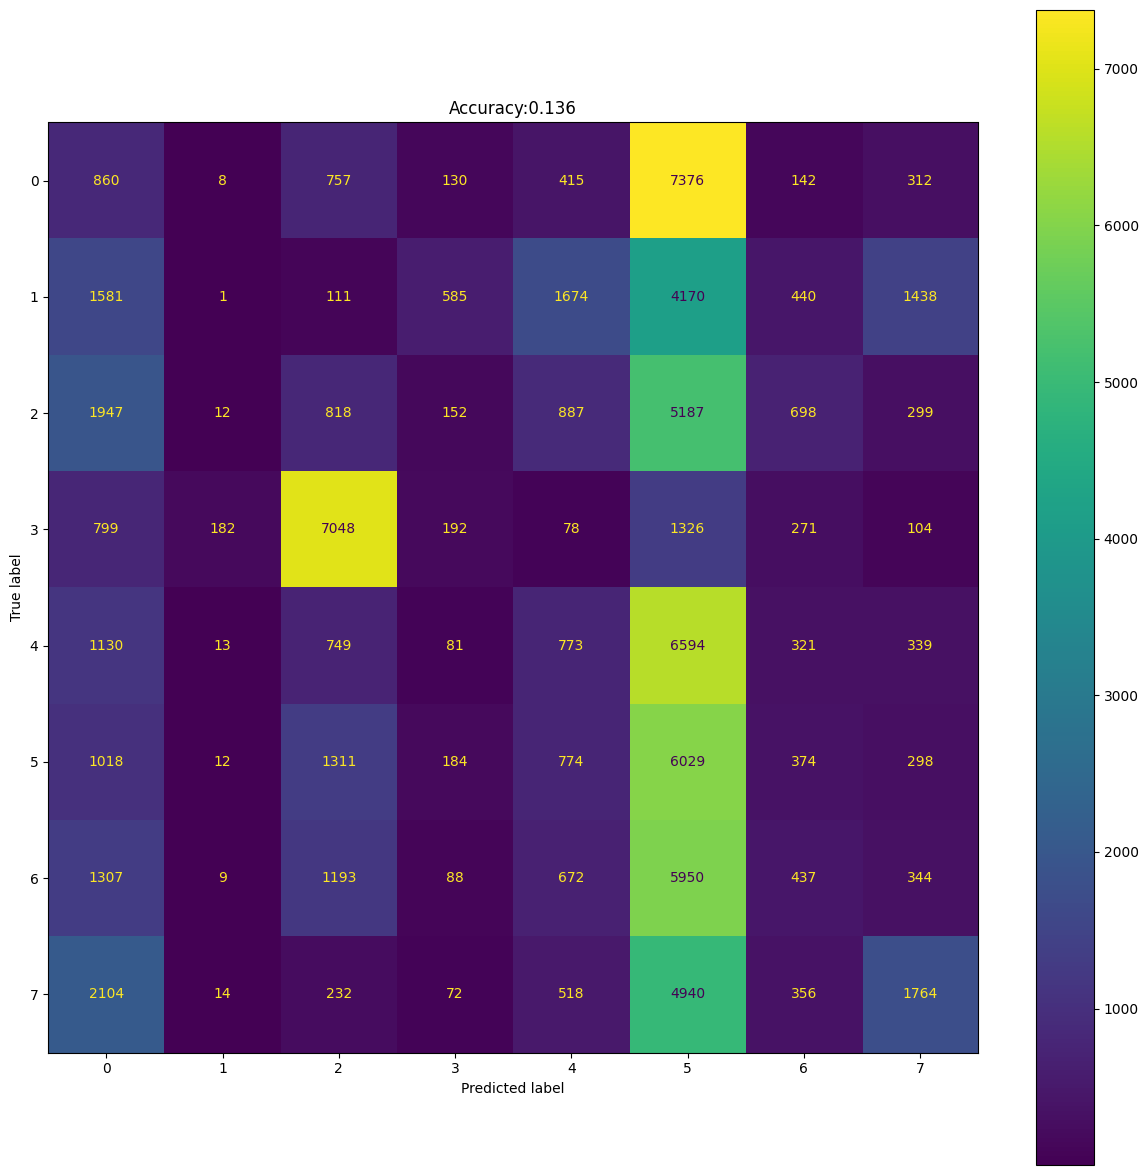

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 3.0437 - accuracy: 0.1680
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.9999 - accuracy: 0.2723
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7372 - accuracy: 0.3515
Epoch 4/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.6445 - accuracy: 0.3878
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5979 - accuracy: 0.4083
Epoch 6/30
2500/2500 [==============================] - 8s 3ms/step - loss: 1.5679 - accuracy: 0.4207
Epoch 7/30
2500/2500 [==============================] - 9s 3ms/step - loss: 1.5454 - accuracy: 0.4306
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5265 - accuracy: 0.4399
Epoch 9/30
2500/2500 [==============================] - 8s 3ms/step - loss: 1.5105 - accuracy: 0.4506
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.

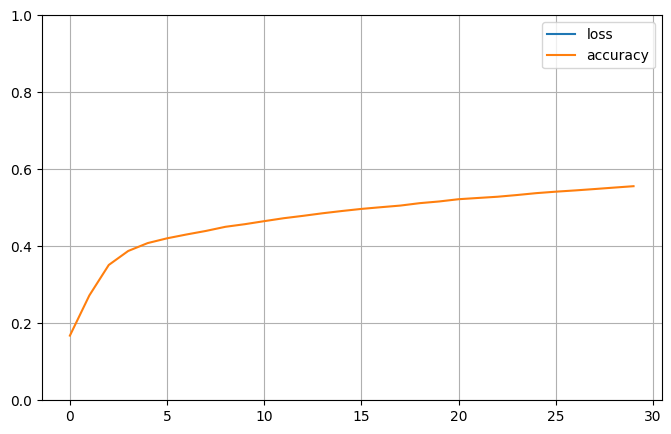

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.3093 - accuracy: 0.5561
test loss, test acc: [1.309282898902893, 0.5560874938964844]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 3 3 ... 7 7 0]
4
[[5363  368  905  537  640  789  665  733]
 [ 165 8906   63   44   27   36  420  339]
 [1652  379 3208  702  749 1188  936 1186]
 [ 244   13  273 8719   38  150  440  123]
 [1530  196  828  506 4187  645  573 1535]
 [2226  330 1667  885  834 2256  872  930]
 [1088  344  876  790  303  493 5430  676]
 [ 412  742  842  271  623  304  388 6418]]
              precision    recall  f1-score   support

           0       0.42      0.54      0.47     10000
           1       0.79      0.89      0.84     10000
           2       0.37      0.32      0.34     10000
           3       0.70      0.87      0.78     10000
           4       0.57      0.42      0.48     10000
           5       0.38      0.23      0.28     10000
           6       0.56      0.54      0.55     10000
           7       0.54      0.64      0.59     10000

    accuracy                           0.56     80000
   macro avg       0.54      0.56  

Test Accuracy:0.5560875


Text(0.5, 1.0, 'Accuracy:0.556')

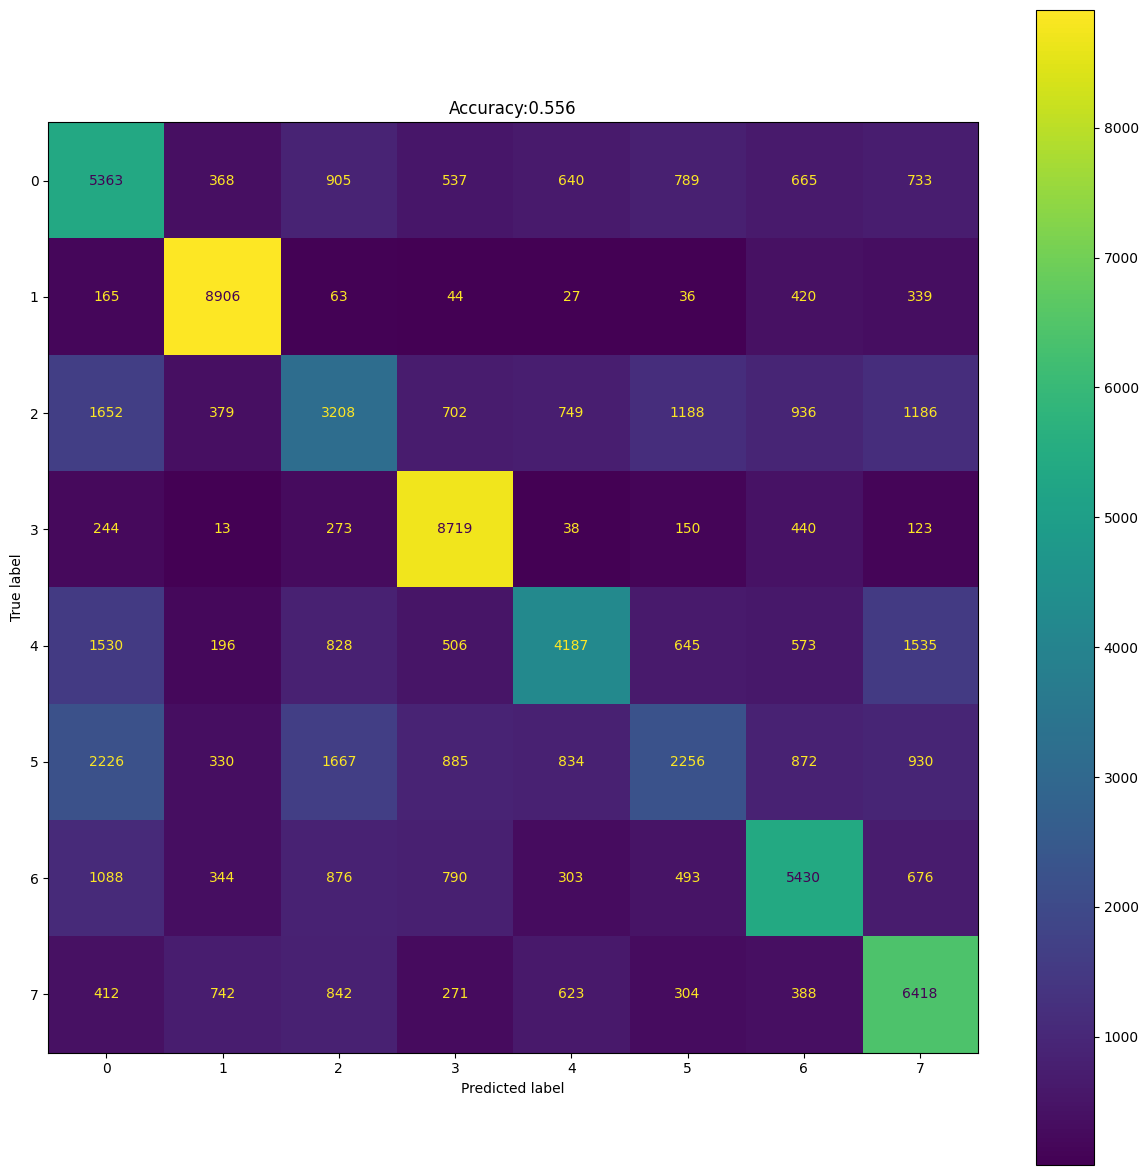

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-25(ii) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 5.4341 - accuracy: 0.1291
test loss, test acc: [5.434119701385498, 0.12907500565052032]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[2 5 5 ... 5 5 2]
2
[[  77    5  476  151  491 8715   15   70]
 [ 418   61  976  288 2229 5612  308  108]
 [ 208    8 1248  342  438 7708   30   18]
 [ 259   11 4330  509  317 4414  135   25]
 [ 232   14  934   92  409 8249   44   26]
 [ 113    9  875  274  736 7938   19   36]
 [ 279    5 1112  259  736 7549   25   35]
 [ 916   60 1531 1562 1460 4336   76   59]]
              precision    recall  f1-score   support

           0       0.03      0.01      0.01     10000
           1       0.35      0.01      0.01     10000
           2       0.11      0.12      0.12     10000
           3       0.15      0.05      0.08     10000
           4       0.06      0.04      0.05     10000
           5       0.15      0.79      0.25     10000
           6       0.04      0.00      0.00     10000
           7       0.16      0.01      0.01     10000

    accuracy                           0.13     80000
   macro avg       0.13      0.13  

Test Accuracy:0.129075


Text(0.5, 1.0, 'Accuracy:0.129')

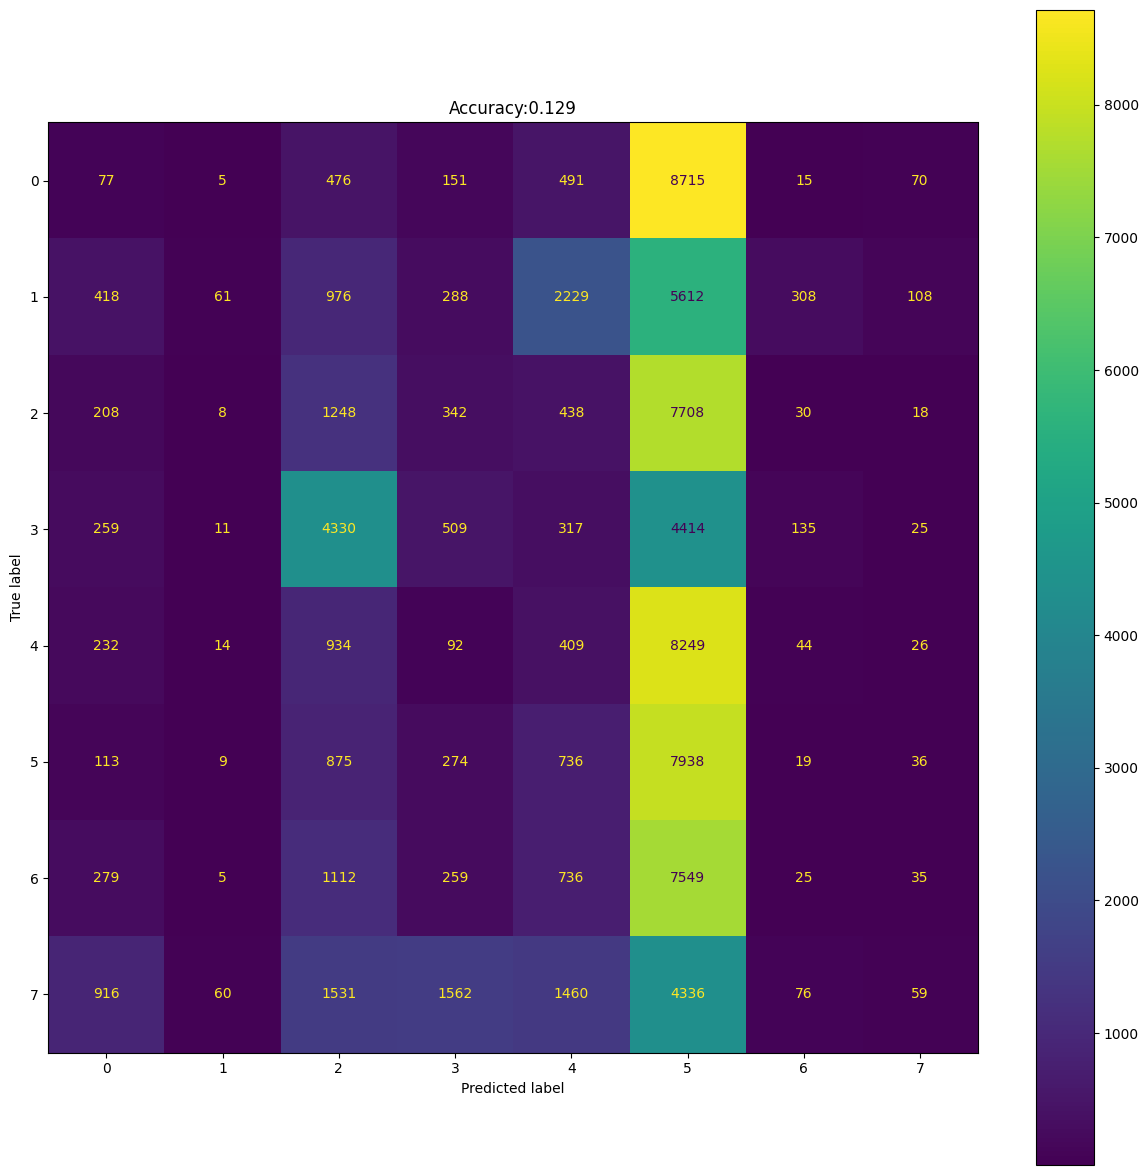

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-25(ii) dataset 

In [30]:
model = keras.models.load_model("//Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 3.1560 - accuracy: 0.1214
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.0850 - accuracy: 0.2052
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8517 - accuracy: 0.2928
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7725 - accuracy: 0.3361
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7269 - accuracy: 0.3591
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6941 - accuracy: 0.3785
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6668 - accuracy: 0.3937
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6437 - accuracy: 0.4054
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6233 - accuracy: 0.4147
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

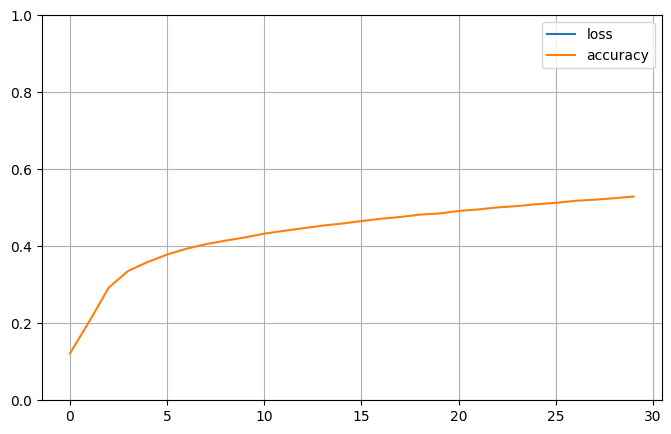

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.3837 - accuracy: 0.5334
test loss, test acc: [1.3837305307388306, 0.533424973487854]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[7 0 0 ... 2 7 7]
7
[[5493  339  751  508 1241  835  308  525]
 [ 139 9233   40  131   49   28  210  170]
 [1256  475 3613  892  887 1282  442 1153]
 [ 341  315  476 7054  482  198  354  780]
 [1462  244  596  773 5076  676  252  921]
 [2039  401 1460  783 1209 3003  372  733]
 [1607  719  988 1118  982  751 2717 1118]
 [ 305  552  741  506 1014  199  198 6485]]
              precision    recall  f1-score   support

           0       0.43      0.55      0.49     10000
           1       0.75      0.92      0.83     10000
           2       0.42      0.36      0.39     10000
           3       0.60      0.71      0.65     10000
           4       0.46      0.51      0.48     10000
           5       0.43      0.30      0.35     10000
           6       0.56      0.27      0.37     10000
           7       0.55      0.65      0.59     10000

    accuracy                           0.53     80000
   macro avg       0.53      0.53  

Test Accuracy:0.533425


Text(0.5, 1.0, 'Accuracy:0.533')

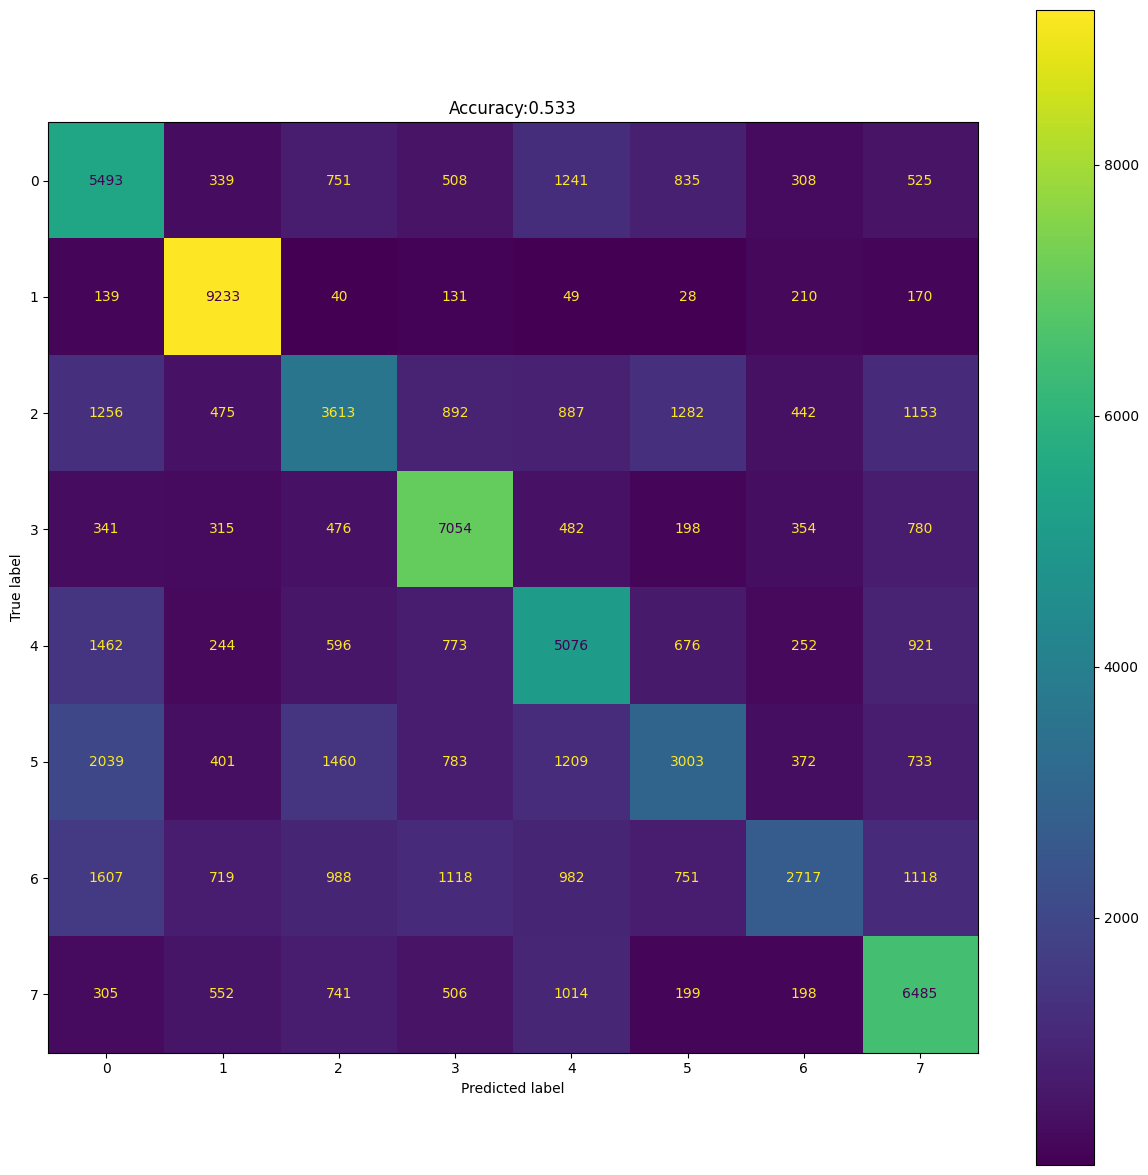

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-30(i) model to Nordic Device-25(ii) dataset 

In [16]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [17]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 6.9827 - accuracy: 0.1376
test loss, test acc: [6.982706069946289, 0.1376499980688095]


In [18]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[6 3 6 ... 3 3 3]
6
[[   6    0 1826  330    0  358 7480    0]
 [  14    0 5795    0   40 4074   77    0]
 [   1    0 7203    4    0  664 2128    0]
 [   0    0 7924    0   11 1648  417    0]
 [   7    0 2859  375    0 1017 5742    0]
 [   2    0 5003    4    0  709 4282    0]
 [   0    0 6627    2    0  402 2969    0]
 [   0    1 2513  573    0 5582 1206  125]]
              precision    recall  f1-score   support

           0       0.20      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.18      0.72      0.29     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.05      0.07      0.06     10000
           6       0.12      0.30      0.17     10000
           7       1.00      0.01      0.02     10000

    accuracy                           0.14     80000
   macro avg       0.19      0.14  

Test Accuracy:0.13765


Text(0.5, 1.0, 'Accuracy:0.138')

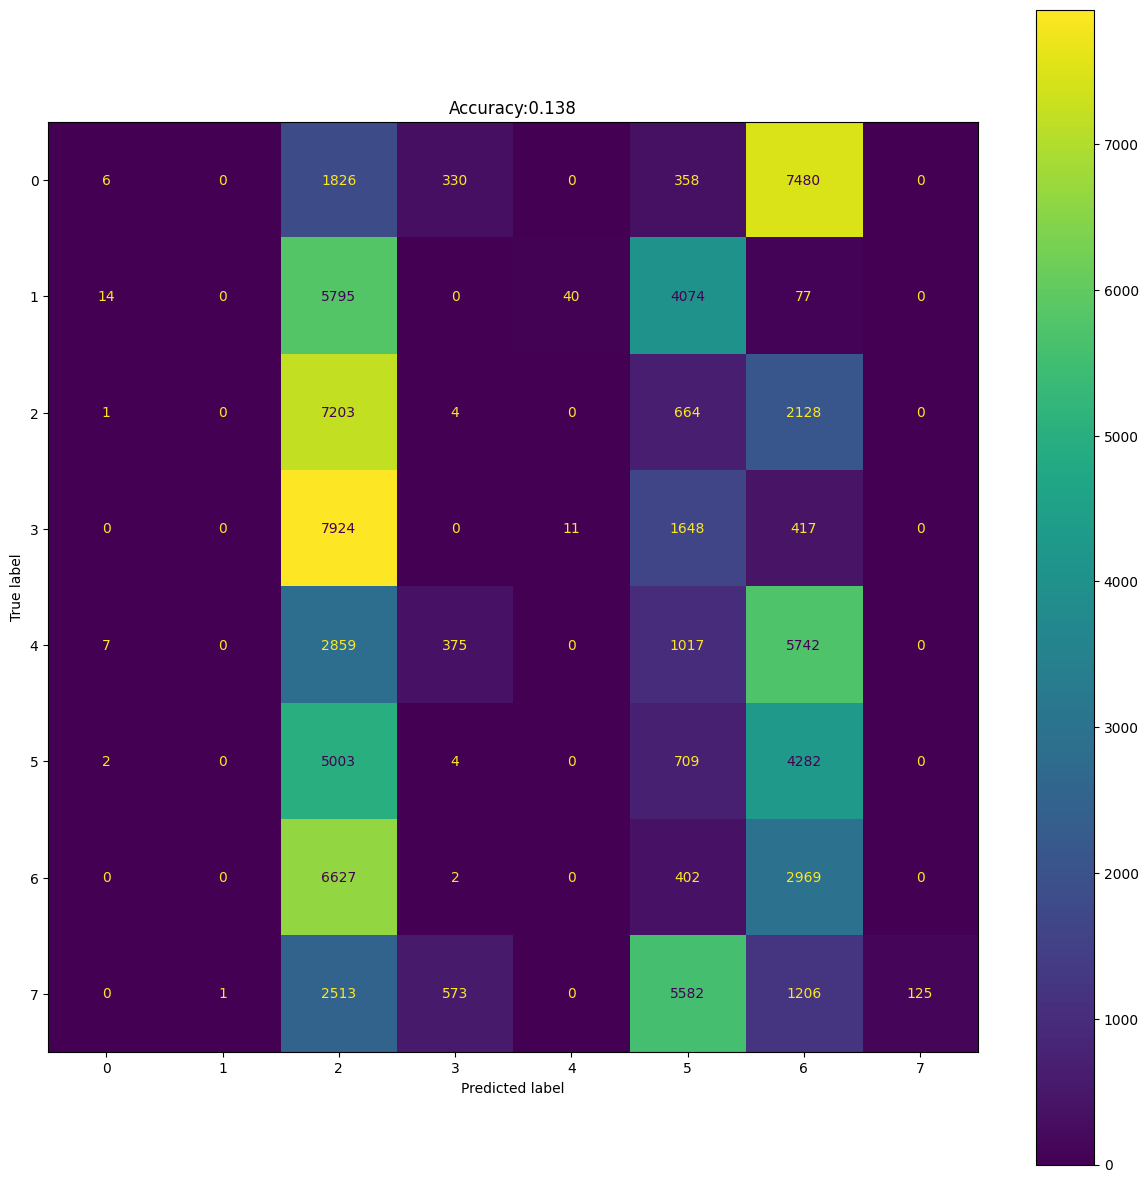

In [19]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [20]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [21]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [22]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.5256 - accuracy: 0.2633
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3597 - accuracy: 0.4893
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1728 - accuracy: 0.5586
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0981 - accuracy: 0.5832
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.0560 - accuracy: 0.5963
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0275 - accuracy: 0.6072
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.0061 - accuracy: 0.6151
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.9893 - accuracy: 0.6202
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.9748 - accuracy: 0.6275
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - lo

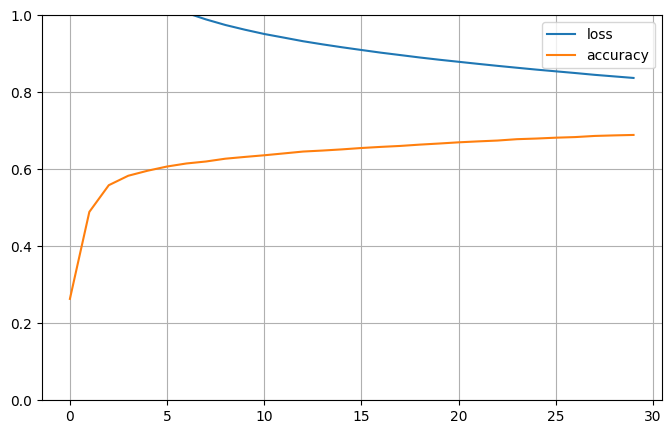

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [24]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.8345 - accuracy: 0.6924
test loss, test acc: [0.8344815373420715, 0.6924375295639038]


In [25]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[0 0 0 ... 7 7 7]
0
[[7582    1  176    0 1389  744    7  101]
 [   9 9588   51  120    2   51   90   89]
 [ 264  138 4678  271  497 2342 1287  523]
 [   0  119   65 9182    1   74  451  108]
 [1979   10  330    0 5970 1161   47  503]
 [ 641   87 1743  132  748 5338  894  417]
 [ 110   73 1489  659  219 1614 5414  422]
 [  35  358  524   51  686  371  332 7643]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.74     10000
           1       0.92      0.96      0.94     10000
           2       0.52      0.47      0.49     10000
           3       0.88      0.92      0.90     10000
           4       0.63      0.60      0.61     10000
           5       0.46      0.53      0.49     10000
           6       0.64      0.54      0.58     10000
           7       0.78      0.76      0.77     10000

    accuracy                           0.69     80000
   macro avg       0.69      0.69   

Test Accuracy:0.6924375


Text(0.5, 1.0, 'Accuracy:0.692')

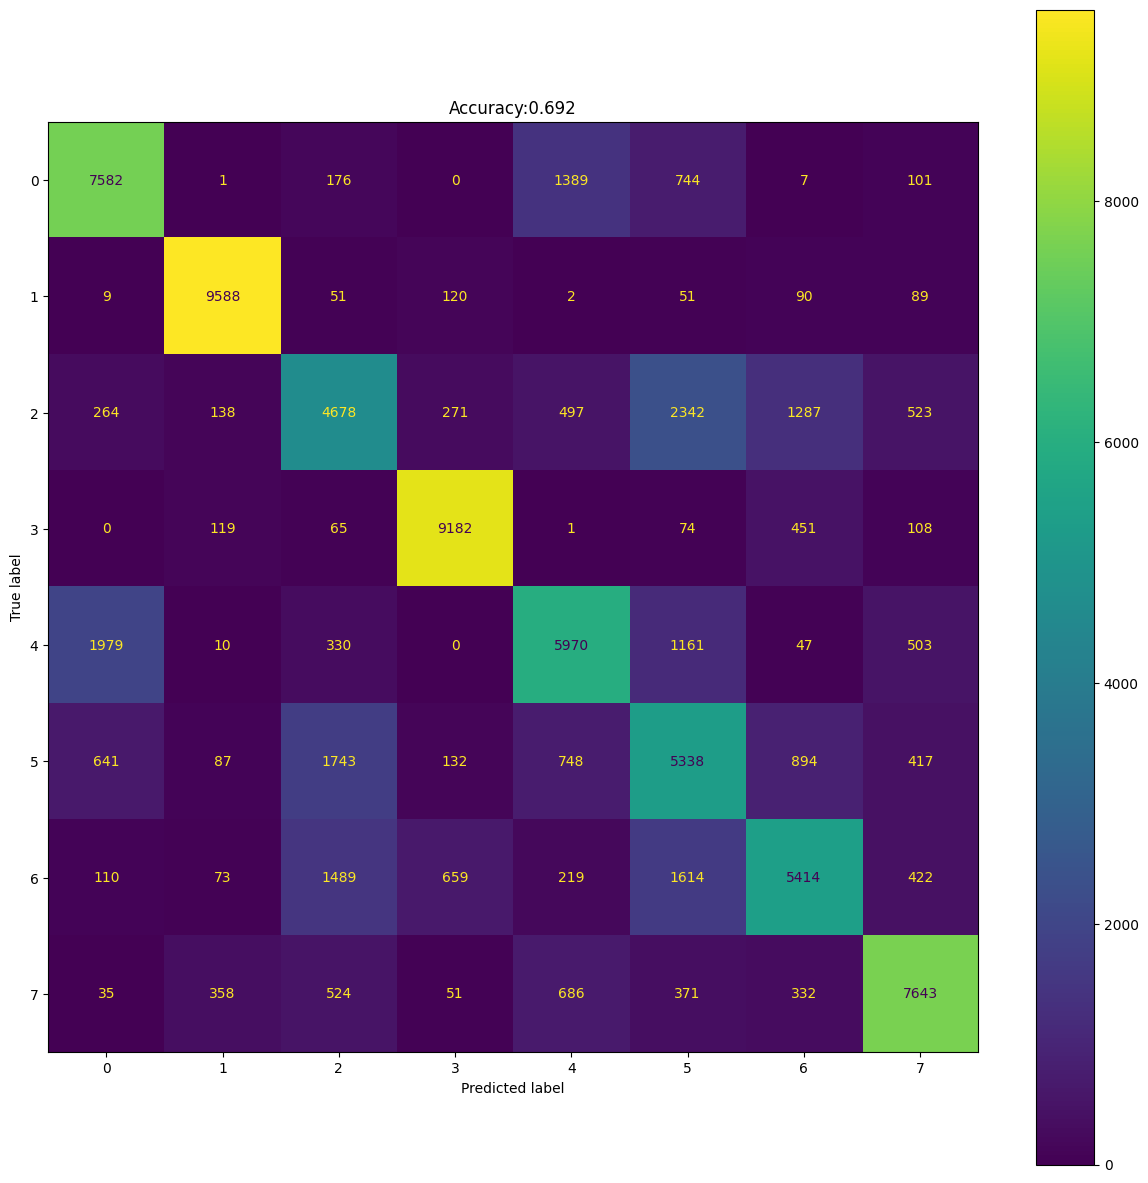

In [26]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-25(ii) dataset 

In [27]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [28]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 4ms/step - loss: 9.0394 - accuracy: 0.1294
test loss, test acc: [9.039430618286133, 0.12943750619888306]


In [29]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 3ms/step
[5 6 6 ... 6 5 5]
5
[[  22    0 2714   21    0 1885 5355    3]
 [1786    0 4529    0    0 3502  183    0]
 [  54    0 3817    0    0 5129  998    2]
 [  70    2 6110    0    0 3775   42    1]
 [   4   18  236    5    0 8175 1540   22]
 [  33    1 3266    0    0 4791 1908    1]
 [  59    1 5615    0    0 3011 1314    0]
 [  86  410 1460    0    0 5903 1730  411]]
              precision    recall  f1-score   support

           0       0.01      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.14      0.38      0.20     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.48      0.21     10000
           6       0.10      0.13      0.11     10000
           7       0.93      0.04      0.08     10000

    accuracy                           0.13     80000
   macro avg       0.16      0.13   

Test Accuracy:0.1294375


Text(0.5, 1.0, 'Accuracy:0.129')

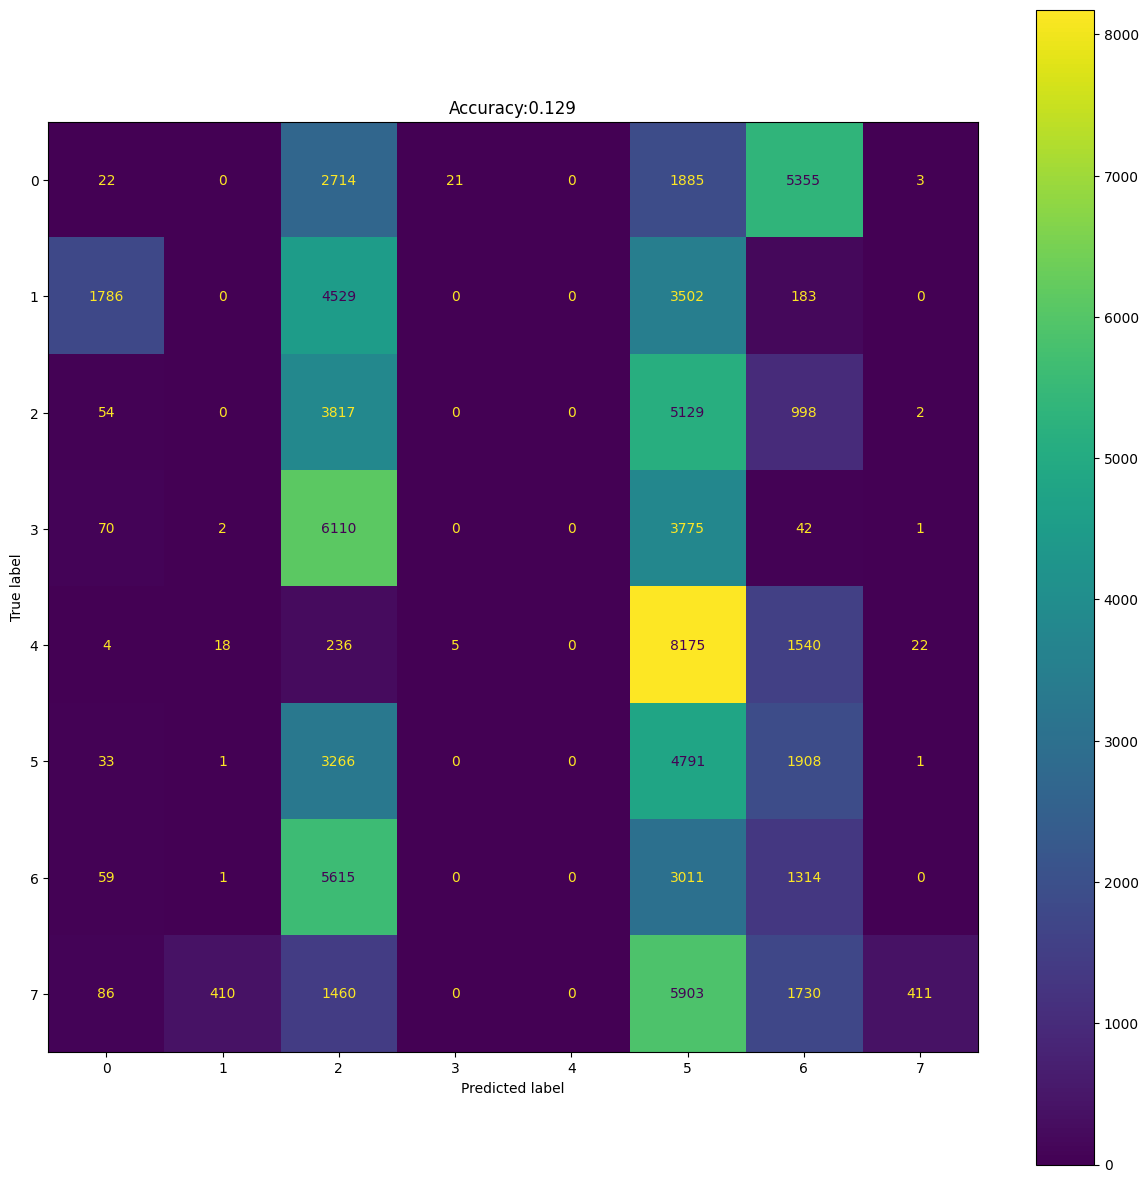

In [30]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [31]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [32]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [33]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8016 - accuracy: 0.2237
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5897 - accuracy: 0.4102
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4297 - accuracy: 0.4714
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3580 - accuracy: 0.4963
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3102 - accuracy: 0.5160
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2726 - accuracy: 0.5330
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2409 - accuracy: 0.5470
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2133 - accuracy: 0.5597
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1889 - accuracy: 0.5709
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss:

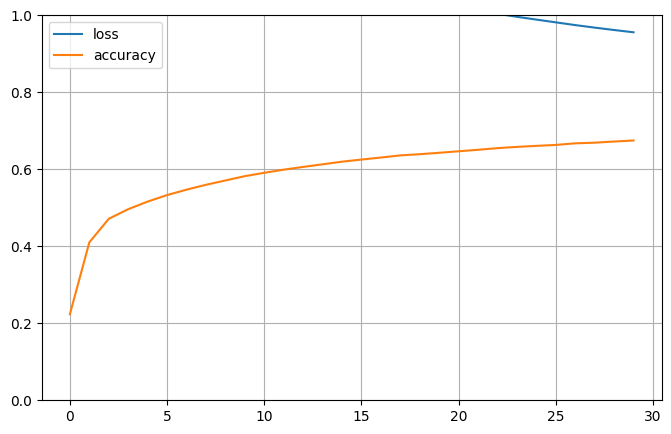

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [35]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.9524 - accuracy: 0.6784
test loss, test acc: [0.9524493217468262, 0.6783999800682068]


In [36]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[0 4 0 ... 7 7 7]
0
[[7373    8  733    5  751  680  310  140]
 [  23 9486   60  231    3    0  172   25]
 [ 741  193 4977  403  691  797 1721  477]
 [   2  395  207 8534    7   16  776   63]
 [ 456    4  431   16 7843  374   65  811]
 [1326   98 2916  198  896 2512 1429  625]
 [ 354  137 1772  723  156  305 6269  284]
 [ 505  293  473   54 1048  149  200 7278]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71     10000
           1       0.89      0.95      0.92     10000
           2       0.43      0.50      0.46     10000
           3       0.84      0.85      0.85     10000
           4       0.69      0.78      0.73     10000
           5       0.52      0.25      0.34     10000
           6       0.57      0.63      0.60     10000
           7       0.75      0.73      0.74     10000

    accuracy                           0.68     80000
   macro avg       0.67      0.68   

Test Accuracy:0.6784


Text(0.5, 1.0, 'Accuracy:0.678')

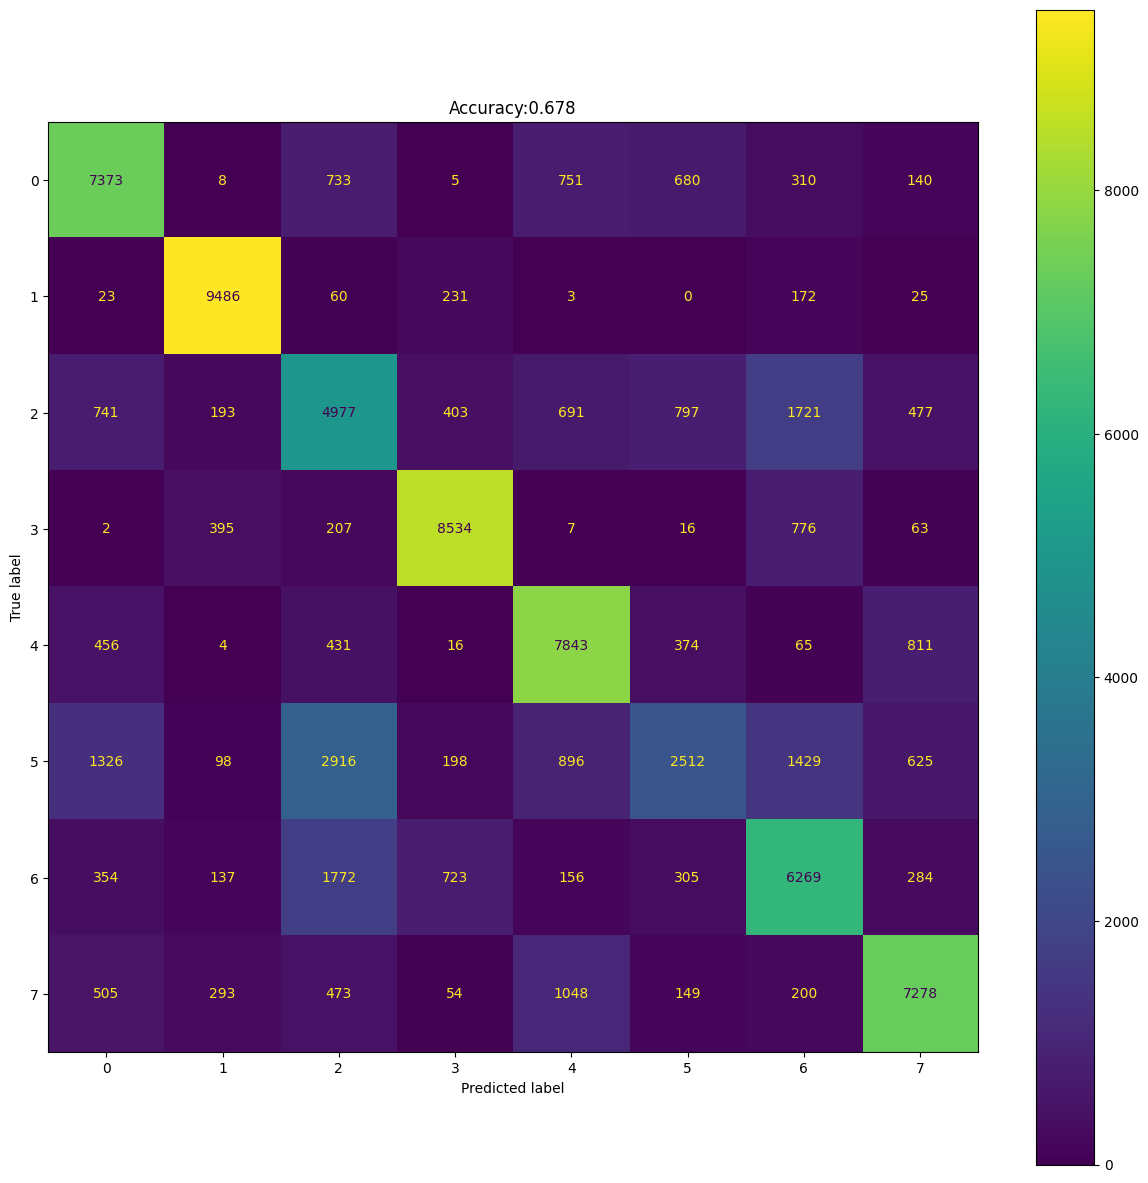

In [37]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-25(ii) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 5.0444 - accuracy: 0.1197
test loss, test acc: [5.044447422027588, 0.11967500299215317]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 4 4 5]
5
[[   3    1 2835  207 1673 4795   87  399]
 [ 528   25 3045 2896 1334  405  769  998]
 [   7    5 1721  287 2176 5284  206  314]
 [   5   61  450   22 1427 7335    2  698]
 [   1    5  418   88  992 8112  378    6]
 [   4    7 1953  220  841 6574  157  244]
 [  16   13 1799  385 1803 5375   97  512]
 [   0   22 2469  677 2274 4010  408  140]]
              precision    recall  f1-score   support

           0       0.01      0.00      0.00     10000
           1       0.18      0.00      0.00     10000
           2       0.12      0.17      0.14     10000
           3       0.00      0.00      0.00     10000
           4       0.08      0.10      0.09     10000
           5       0.16      0.66      0.25     10000
           6       0.05      0.01      0.02     10000
           7       0.04      0.01      0.02     10000

    accuracy                           0.12     80000
   macro avg       0.08      0.12  

Test Accuracy:0.119675


Text(0.5, 1.0, 'Accuracy:0.120')

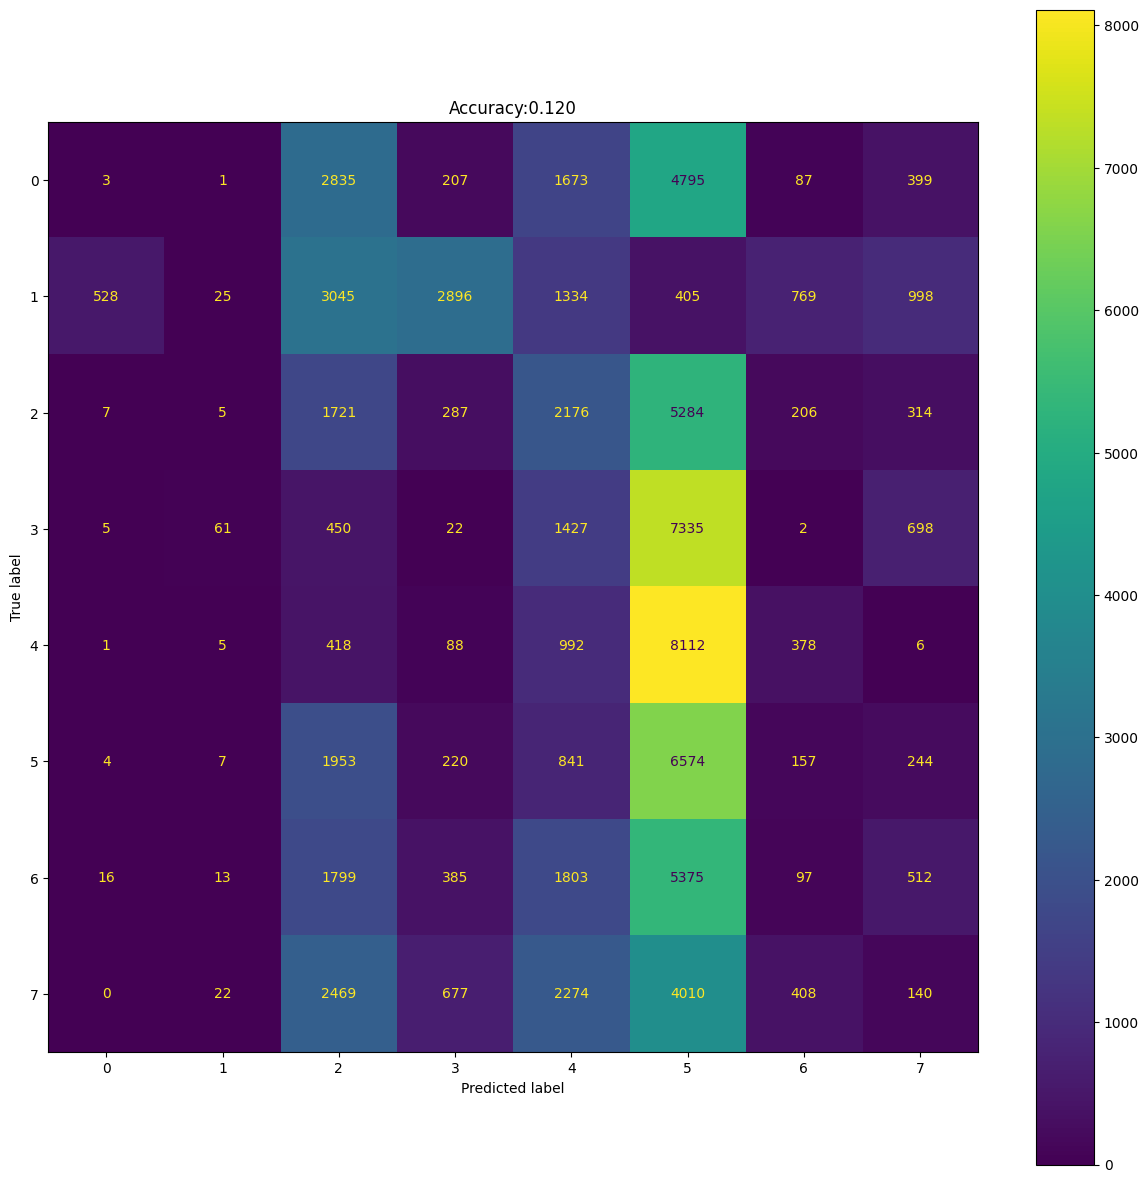

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8848 - accuracy: 0.1502
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7391 - accuracy: 0.3602
Epoch 3/30
2500/2500 [==============================] - 9s 3ms/step - loss: 1.4697 - accuracy: 0.4619
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3825 - accuracy: 0.4973
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3397 - accuracy: 0.5141
Epoch 6/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.3121 - accuracy: 0.5236
Epoch 7/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.2922 - accuracy: 0.5309
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.2759 - accuracy: 0.5371
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2624 - accuracy: 0.5428
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - lo

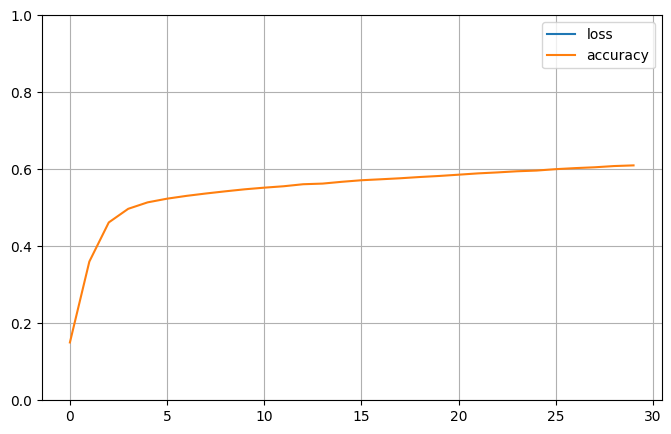

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.1092 - accuracy: 0.6154
test loss, test acc: [1.1091742515563965, 0.6154249906539917]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 5ms/step
[4 4 0 ... 7 7 7]
4
[[6044  116  961  400  637  886  425  531]
 [  26 9509   38    9    8   37  230  143]
 [1482  373 3581  549 1013 1288  863  851]
 [ 202   30  240 8532  295  176  288  237]
 [ 604   22  580  239 7255  559  151  590]
 [1808  210 1678  593 1186 3195  756  574]
 [1145  439  799  669  636  831 4704  777]
 [ 782  234  492  347  842  339  550 6414]]
              precision    recall  f1-score   support

           0       0.50      0.60      0.55     10000
           1       0.87      0.95      0.91     10000
           2       0.43      0.36      0.39     10000
           3       0.75      0.85      0.80     10000
           4       0.61      0.73      0.66     10000
           5       0.44      0.32      0.37     10000
           6       0.59      0.47      0.52     10000
           7       0.63      0.64      0.64     10000

    accuracy                           0.62     80000
   macro avg       0.60      0.62  

Test Accuracy:0.615425


Text(0.5, 1.0, 'Accuracy:0.615')

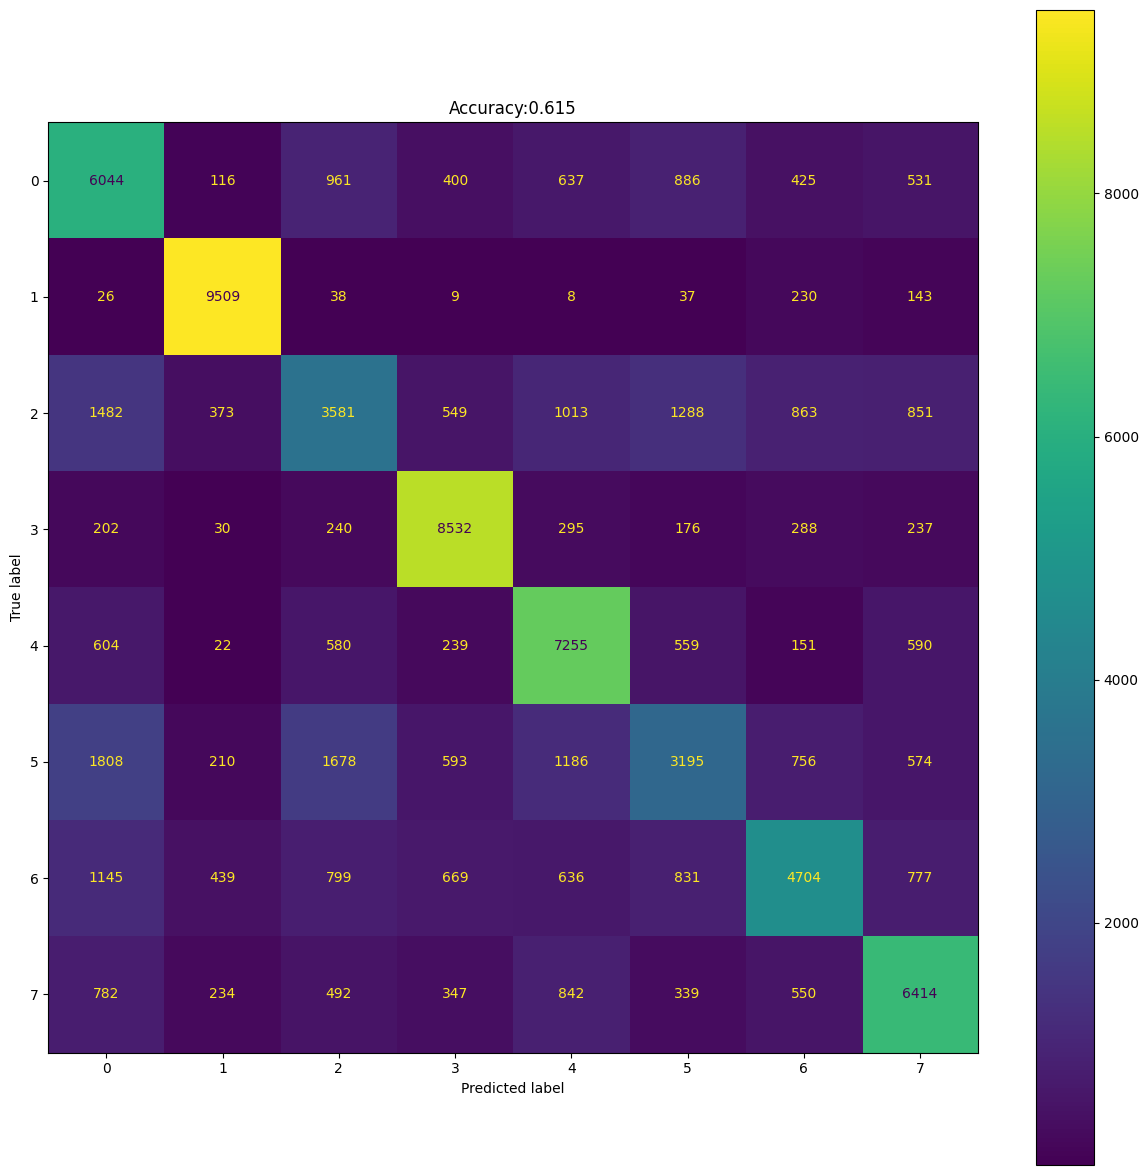

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-25(i) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 6.6472 - accuracy: 0.1059
test loss, test acc: [6.647214889526367, 0.10592500120401382]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[0 5 0 ... 0 2 2]
0
[[2107    0  183   10    0 7696    4    0]
 [ 224    0 2564 1709    0 5119  383    1]
 [1681    0  356    5    0 7951    5    2]
 [5854    0    2    0    0 4144    0    0]
 [2604    0  264    0    0 7128    4    0]
 [3617    0  414    4    0 5965    0    0]
 [ 967    1   69    3    0 8955    3    2]
 [1213   12 1164   40   25 7418   85   43]]
              precision    recall  f1-score   support

           0       0.12      0.21      0.15     10000
           1       0.00      0.00      0.00     10000
           2       0.07      0.04      0.05     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.11      0.60      0.19     10000
           6       0.01      0.00      0.00     10000
           7       0.90      0.00      0.01     10000

    accuracy                           0.11     80000
   macro avg       0.15      0.11  

Test Accuracy:0.105925


Text(0.5, 1.0, 'Accuracy:0.106')

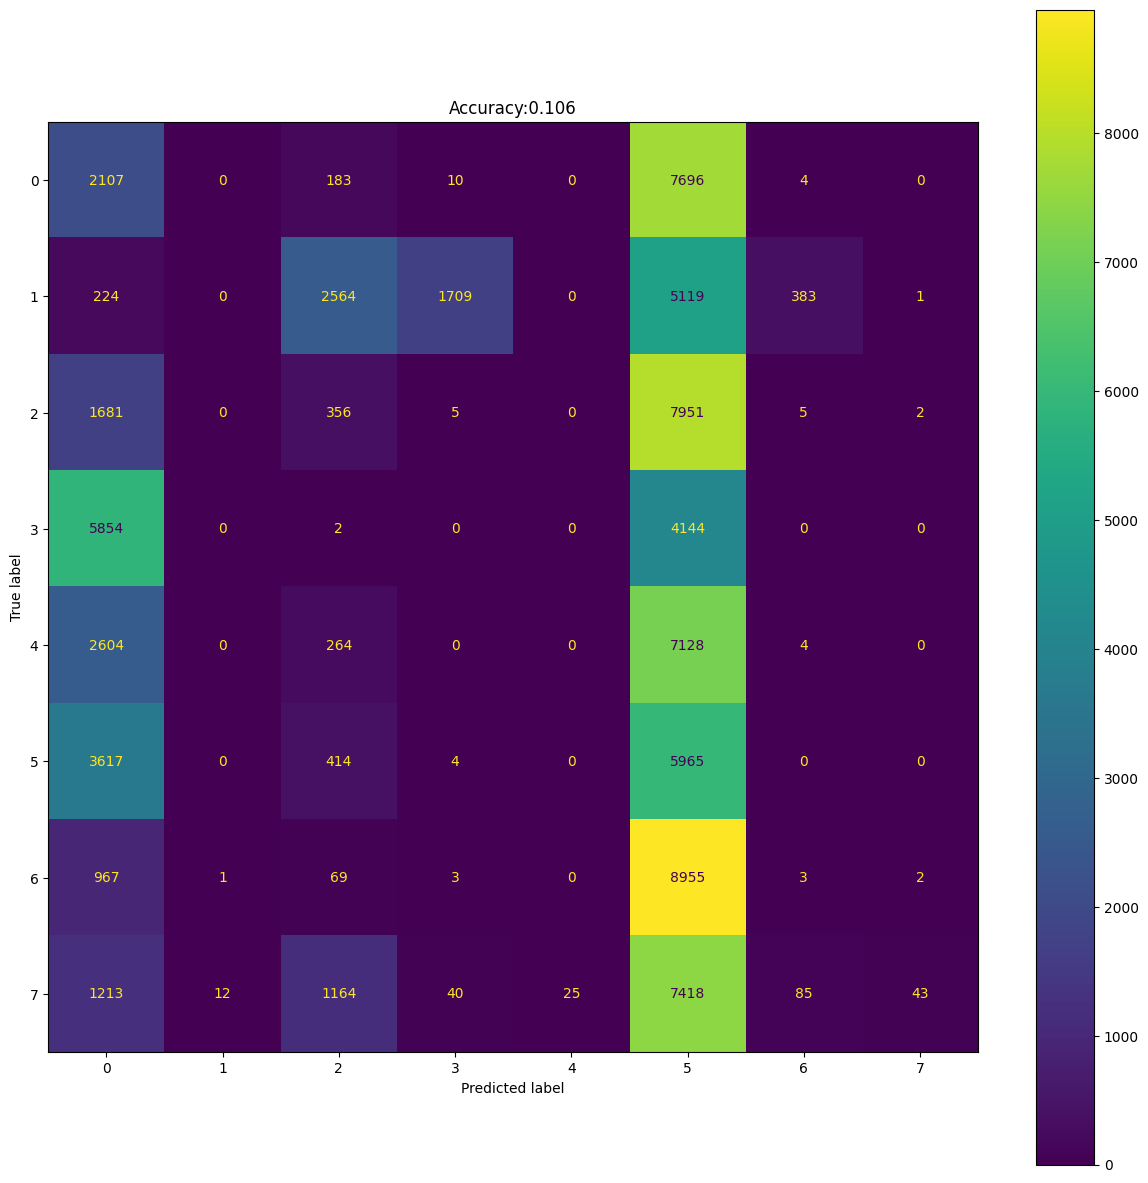

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.7064 - accuracy: 0.1775
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6842 - accuracy: 0.3645
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5056 - accuracy: 0.4292
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4261 - accuracy: 0.4616
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3737 - accuracy: 0.4869
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3337 - accuracy: 0.5066
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3018 - accuracy: 0.5227
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.2744 - accuracy: 0.5368
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.2505 - accuracy: 0.5466
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

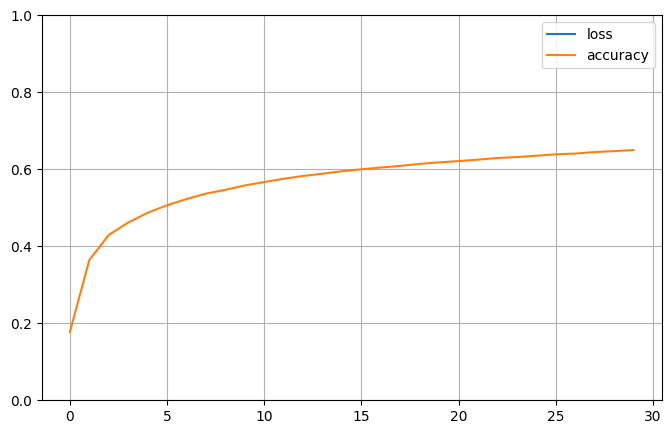

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.0117 - accuracy: 0.6522
test loss, test acc: [1.0117385387420654, 0.6522125005722046]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[6 0 5 ... 7 7 7]
6
[[6019   74  945  292  595 1603  442   30]
 [   1 9162   11    3    6   28   73  716]
 [1352  218 3675  304  791 2109 1083  468]
 [ 204    0  179 8517  187  391  486   36]
 [ 517   55  548  602 6045 1290  478  465]
 [1451  146 1300  542  985 5098  309  169]
 [ 391  102  615  560  504  364 6802  662]
 [  39  724  252  134  607  261 1124 6859]]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60     10000
           1       0.87      0.92      0.89     10000
           2       0.49      0.37      0.42     10000
           3       0.78      0.85      0.81     10000
           4       0.62      0.60      0.61     10000
           5       0.46      0.51      0.48     10000
           6       0.63      0.68      0.65     10000
           7       0.73      0.69      0.71     10000

    accuracy                           0.65     80000
   macro avg       0.65      0.65  

Test Accuracy:0.6522125


Text(0.5, 1.0, 'Accuracy:0.652')

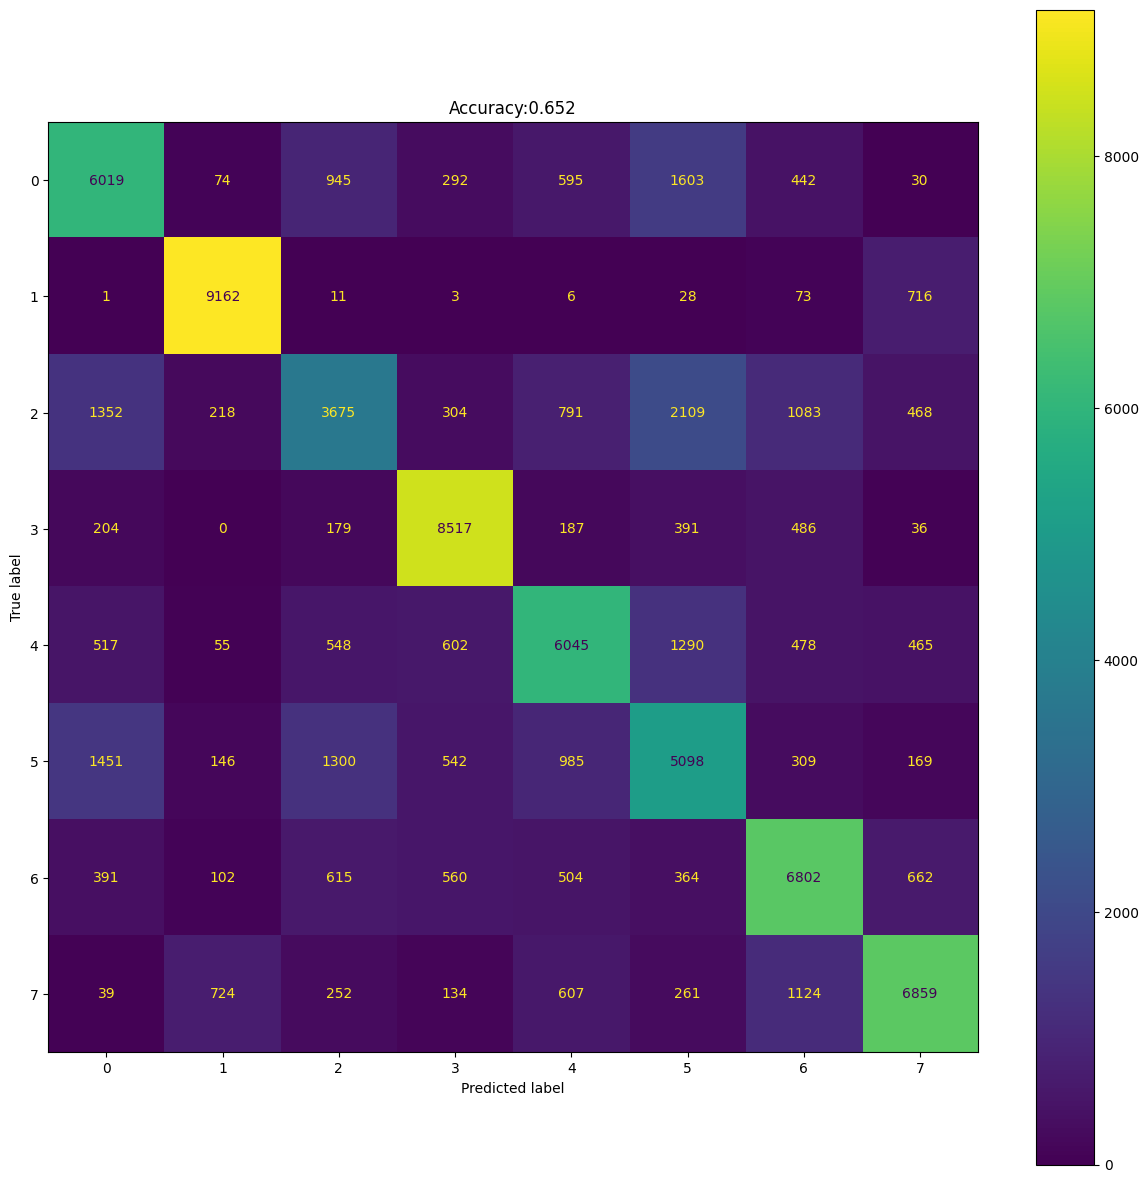

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-25(i) dataset 

In [59]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [60]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 5.6015 - accuracy: 0.1249
test loss, test acc: [5.601542949676514, 0.12487500160932541]


In [61]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[0 0 0 ... 0 0 0]
0
[[5095    0   99   29    0 4765    1   11]
 [1752   55 6591  625   11  560  406    0]
 [4171    0  279  104    0 5438    1    7]
 [1912   96   11  153    0 7493    0  335]
 [5411    0   47    9    0 4527    4    2]
 [5280    1  263   58    0 4386    3    9]
 [4804    0  271   96    0 4803    7   19]
 [5639   29  746  326    1 3234   10   15]]
              precision    recall  f1-score   support

           0       0.15      0.51      0.23     10000
           1       0.30      0.01      0.01     10000
           2       0.03      0.03      0.03     10000
           3       0.11      0.02      0.03     10000
           4       0.00      0.00      0.00     10000
           5       0.12      0.44      0.19     10000
           6       0.02      0.00      0.00     10000
           7       0.04      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.10      0.12  

Test Accuracy:0.124875


Text(0.5, 1.0, 'Accuracy:0.125')

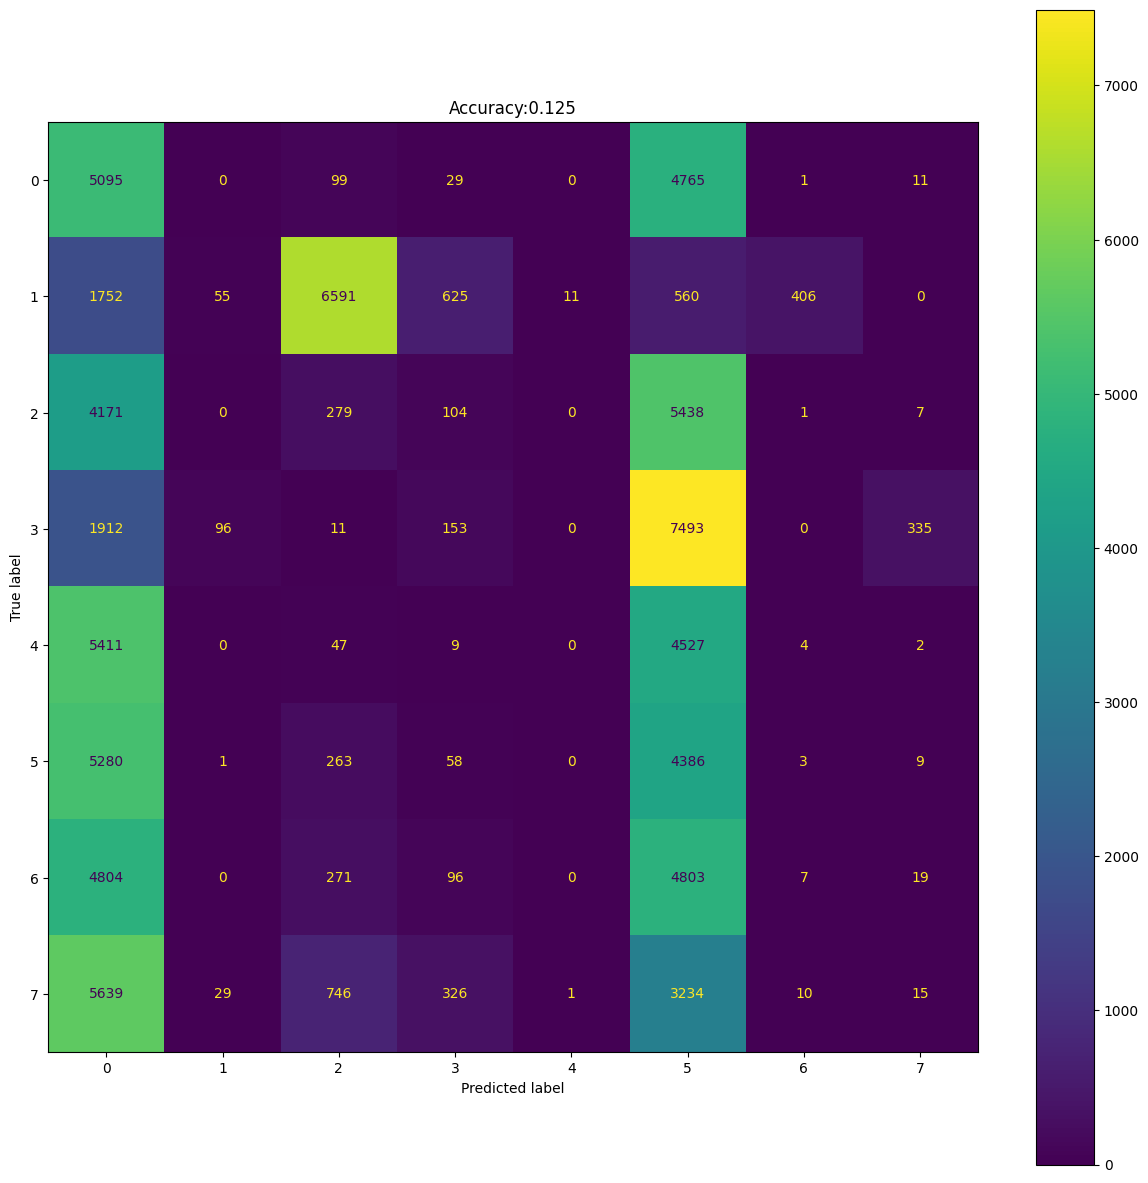

In [62]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [63]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [64]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [65]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.5456 - accuracy: 0.2025
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7749 - accuracy: 0.3318
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5683 - accuracy: 0.3878
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4649 - accuracy: 0.4339
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4015 - accuracy: 0.4686
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3581 - accuracy: 0.4915
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3256 - accuracy: 0.5086
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2996 - accuracy: 0.5231
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2775 - accuracy: 0.5328
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

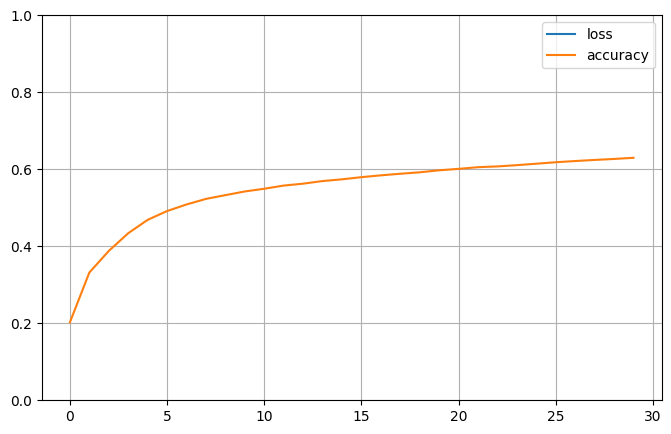

In [66]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [67]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.0623 - accuracy: 0.6275
test loss, test acc: [1.0623397827148438, 0.6275249719619751]


In [68]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 0 5 ... 7 7 7]
4
[[5735    9  618  410 1045 1785  294  104]
 [   0 9537   10    1    1   21   19  411]
 [1689   62 2490  868 1028 2715  607  541]
 [ 468    5  188 8498  287  213  234  107]
 [ 791    9  210  487 6846  938  222  497]
 [1989   27 1062  622 1080 4476  312  432]
 [ 951  112  467  660 1141  738 4601 1330]
 [  64  467   48  143  760   90  409 8019]]
              precision    recall  f1-score   support

           0       0.49      0.57      0.53     10000
           1       0.93      0.95      0.94     10000
           2       0.49      0.25      0.33     10000
           3       0.73      0.85      0.78     10000
           4       0.56      0.68      0.62     10000
           5       0.41      0.45      0.43     10000
           6       0.69      0.46      0.55     10000
           7       0.70      0.80      0.75     10000

    accuracy                           0.63     80000
   macro avg       0.62      0.63  

Test Accuracy:0.627525


Text(0.5, 1.0, 'Accuracy:0.628')

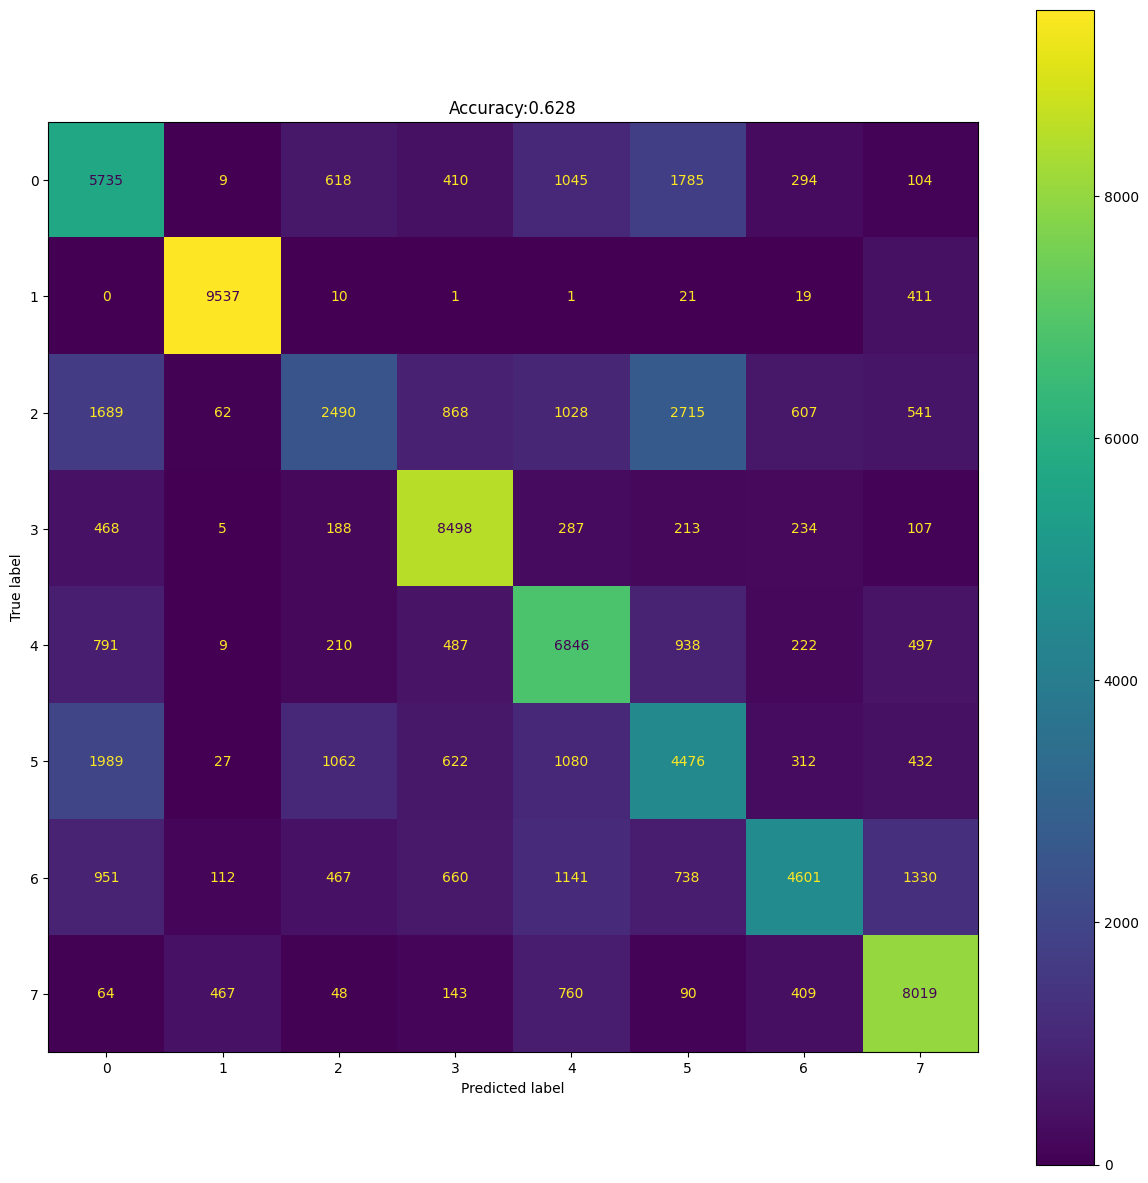

In [69]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')